In [2]:
import numpy as np
import torch

# Define local dataset paths
synthetic_eeg_eog_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/Linear_synthetic_eeg_eog.npy"
clean_eeg_path = "/home/tulgaa/Desktop/denoisenet/Linear_Mixing/EEG+EOG/EEG_all_epochs.npy"

# Load dataset
synthetic_eeg_eog = np.load(synthetic_eeg_eog_path, allow_pickle=True).item()  # Dictionary of SNR levels
clean_eeg = np.load(clean_eeg_path)  # Ground truth EEG

# Check dataset properties
print("🔹 SNR Levels:", synthetic_eeg_eog.keys())
print("🔹 Clean EEG Shape:", clean_eeg.shape)

for snr in synthetic_eeg_eog.keys():
    print(f"🔹 SNR Level {snr}: Shape = {synthetic_eeg_eog[snr].shape}")

# Convert to PyTorch tensors
synthetic_eeg_eog_tensors = {snr: torch.tensor(synthetic_eeg_eog[snr], dtype=torch.float32) for snr in synthetic_eeg_eog.keys()}
clean_eeg_tensor = torch.tensor(clean_eeg, dtype=torch.float32)

print("\n✅ Dataset successfully loaded and converted to tensors!")


🔹 SNR Levels: dict_keys([-7, -6, -5, -4, -3, -2, -1, 0, 1, 2])
🔹 Clean EEG Shape: (3400, 512)
🔹 SNR Level -7: Shape = (3400, 512)
🔹 SNR Level -6: Shape = (3400, 512)
🔹 SNR Level -5: Shape = (3400, 512)
🔹 SNR Level -4: Shape = (3400, 512)
🔹 SNR Level -3: Shape = (3400, 512)
🔹 SNR Level -2: Shape = (3400, 512)
🔹 SNR Level -1: Shape = (3400, 512)
🔹 SNR Level 0: Shape = (3400, 512)
🔹 SNR Level 1: Shape = (3400, 512)
🔹 SNR Level 2: Shape = (3400, 512)

✅ Dataset successfully loaded and converted to tensors!


In [3]:
import torch
from sklearn.model_selection import train_test_split

# Store train/test data separately
X_train_list, X_test_list = [], []
y_train_list, y_test_list = [], []

# Loop through each SNR level and split data
for snr in synthetic_eeg_eog_tensors.keys():
    contaminated_signals = synthetic_eeg_eog_tensors[snr]  # Noisy EEG for this SNR level
    clean_signals = clean_eeg_tensor  # Corresponding clean EEG

    # Ensure both datasets match in order
    assert contaminated_signals.shape == clean_signals.shape, f"Shape mismatch at SNR {snr}"

    # Split 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(
        contaminated_signals, clean_signals, test_size=0.2, random_state=42
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

# Stack all SNR-level data
X_train_final = torch.cat(X_train_list, dim=0)
X_test_final = torch.cat(X_test_list, dim=0)
y_train_final = torch.cat(y_train_list, dim=0)
y_test_final = torch.cat(y_test_list, dim=0)

# Print shapes
print("✅ Training Data Shape:", X_train_final.shape)
print("✅ Testing Data Shape:", X_test_final.shape)


✅ Training Data Shape: torch.Size([27200, 512])
✅ Testing Data Shape: torch.Size([6800, 512])


In [4]:
import torch
import torch.nn as nn

class DiRBlock(nn.Module):
    """
    Implements a single DiR Block with:
    - Pre-Norm (Layer Normalization)
    - Multi-Scale Retention (MSR)
    - Residual Connection
    - Feedforward Network (FFN)
    """
    def __init__(self, embed_dim=512, num_heads=8, retention_size=512):
        super(DiRBlock, self).__init__()

        # Pre-Norm before retention mechanism
        self.norm1 = nn.LayerNorm(embed_dim)

        # Multi-Scale Retention (MSR)
        self.retention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

        # Residual Connection
        self.norm2 = nn.LayerNorm(embed_dim)

        # Feedforward Network (FFN)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, retention_size),
            nn.ReLU(),
            nn.Linear(retention_size, embed_dim)
        )

    def forward(self, x):
        """
        Forward pass for the DiR block.
        """
        # Pre-Normalization & Multi-Scale Retention
        residual = x
        x = self.norm1(x)
        x, _ = self.retention(x, x, x)
        x = residual + x  # Residual Connection

        # Pre-Normalization & Feedforward Network (FFN)
        residual = x
        x = self.norm2(x)
        x = self.ffn(x)
        
        return residual + x  # Final Residual Connection


In [5]:
class EEGDiR(nn.Module):
    """
    EEGDiR Model for EEG Denoising using the Retentive Network.
    """
    def __init__(self, seq_len=512, embed_dim=512, num_blocks=4, num_heads=8):
        super(EEGDiR, self).__init__()

        # Signal Embedding: Convert EEG (1D 512) → (Hidden dim 512)
        self.embedding = nn.Linear(seq_len, embed_dim)

        # Stacked Retentive Blocks (DiR Blocks)
        self.dir_blocks = nn.Sequential(*[DiRBlock(embed_dim, num_heads) for _ in range(num_blocks)])

        # Output Projection: Convert back to original EEG dimension
        self.output_layer = nn.Linear(embed_dim, seq_len)

    def forward(self, x):
        """
        Forward pass through EEGDiR.
        """
        x = self.embedding(x)  # Project input EEG to hidden dimension
        x = self.dir_blocks(x)  # Pass through DiR blocks
        x = self.output_layer(x)  # Convert back to original EEG format
        return x

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGDiR().to(device)
print(model)


EEGDiR(
  (embedding): Linear(in_features=512, out_features=512, bias=True)
  (dir_blocks): Sequential(
    (0): DiRBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (retention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (1): DiRBlock(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (retention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
      )
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=512, out_features=512, bias=True)
        (1

In [6]:
sample_input = torch.randn(1, 512).to(device)  # Simulated EEG signal
output = model(sample_input)
print("✅ Model Output Shape:", output.shape)


✅ Model Output Shape: torch.Size([1, 512])


In [7]:
import torch.optim as optim

# Define loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define optimizer (AdamW for stable training)
optimizer = optim.AdamW(model.parameters(), lr=5e-5)

# Early Stopping Parameters
patience = 10  # Stop training if validation loss does not improve for 10 epochs
best_val_loss = float('inf')
epochs_no_improve = 0


In [8]:
import time

def train_model(model, X_train, y_train, X_test, y_test, epochs=100, batch_size=1024):
    global best_val_loss, epochs_no_improve
    model.train()

    # Move tensors to GPU
    X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

    # Create Data Loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        start_time = time.time()
        train_loss = 0.0

        # Training loop
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to GPU
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Compute average training loss
        avg_train_loss = train_loss / len(train_loader)
        
        # Validation loss calculation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in test_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)  # Move data to GPU
                val_output = model(X_val)
                val_loss += criterion(val_output, y_val).item()
        
        avg_val_loss = val_loss / len(test_loader)
        elapsed_time = time.time() - start_time

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f} - Time: {elapsed_time:.2f}s")

        # Early Stopping Logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), "c")  # Save the best model
            print("✅ Model improved! Saving checkpoint.")
        else:
            epochs_no_improve += 1
            print(f"⚠️ No improvement for {epochs_no_improve} epochs.")

        if epochs_no_improve >= patience:
            print("⏹️ Early stopping triggered!")
            break

        model.train()  # Switch back to training mode

# Start Training with CUDA
train_model(model, X_train_final, y_train_final, X_test_final, y_test_final, epochs=1000, batch_size=1024)


Epoch [1/1000] - Train Loss: 80697.628762 - Val Loss: 67063.164062 - Time: 0.75s
✅ Model improved! Saving checkpoint.
Epoch [2/1000] - Train Loss: 62292.257089 - Val Loss: 57673.392857 - Time: 0.59s
✅ Model improved! Saving checkpoint.
Epoch [3/1000] - Train Loss: 54937.825231 - Val Loss: 52526.223214 - Time: 0.62s
✅ Model improved! Saving checkpoint.
Epoch [4/1000] - Train Loss: 50277.579282 - Val Loss: 48653.642299 - Time: 0.64s
✅ Model improved! Saving checkpoint.
Epoch [5/1000] - Train Loss: 46529.553241 - Val Loss: 45291.113839 - Time: 0.57s
✅ Model improved! Saving checkpoint.
Epoch [6/1000] - Train Loss: 43190.654369 - Val Loss: 42251.420201 - Time: 0.66s
✅ Model improved! Saving checkpoint.
Epoch [7/1000] - Train Loss: 40225.307002 - Val Loss: 39567.566964 - Time: 0.59s
✅ Model improved! Saving checkpoint.
Epoch [8/1000] - Train Loss: 37684.406973 - Val Loss: 37271.170201 - Time: 0.57s
✅ Model improved! Saving checkpoint.
Epoch [9/1000] - Train Loss: 35483.052807 - Val Loss: 35

In [31]:
import numpy as np
from scipy.signal import welch

def calculate_rrmse_temporal(clean_signal, denoised_signal):
    """Calculate RRMSE in the temporal domain."""
    rrmse_t = np.sqrt(np.mean((clean_signal - denoised_signal) ** 2)) / np.sqrt(np.mean(clean_signal ** 2))
    return rrmse_t

def calculate_rrmse_spectral(clean_signal, denoised_signal, fs=256):
    """Calculate RRMSE in the spectral domain."""
    f_clean, psd_clean = welch(clean_signal, fs=fs, nperseg=256)
    f_denoised, psd_denoised = welch(denoised_signal, fs=fs, nperseg=256)
    rrmse_s = np.sqrt(np.mean((psd_clean - psd_denoised) ** 2)) / np.sqrt(np.mean(psd_clean ** 2))
    return rrmse_s

def calculate_correlation_coefficient(clean_signal, denoised_signal):
    """Calculate the Correlation Coefficient (CC) between clean and denoised signals."""
    cc = np.corrcoef(clean_signal, denoised_signal)[0, 1]
    return cc

# Evaluate for each SNR level
results = {snr: {"rrmse_t": [], "rrmse_s": [], "cc": []} for snr in synthetic_eeg_eog.keys()}

for snr in synthetic_eeg_eog.keys():
    print(f"🔎 Evaluating model for SNR {snr} dB...")
    
    # Load the trained EEGDiR model
    model = EEGDiR().to(device)
    model.load_state_dict(torch.load("c"))
    model.eval()
    
    # Get noisy and clean data for this SNR level
    X_snr = torch.tensor(synthetic_eeg_eog[snr], dtype=torch.float32).to(device)
    y_snr = torch.tensor(clean_eeg, dtype=torch.float32).to(device)
    
    # Get denoised signals
    with torch.no_grad():
        denoised_signals = model(X_snr).cpu().numpy()
        clean_signals = y_snr.cpu().numpy()
    
    # Compute metrics for each EEG sample
    for clean_signal, denoised_signal in zip(clean_signals, denoised_signals):
        rrmse_t = calculate_rrmse_temporal(clean_signal, denoised_signal)
        rrmse_s = calculate_rrmse_spectral(clean_signal, denoised_signal)
        cc = calculate_correlation_coefficient(clean_signal, denoised_signal)
        
        results[snr]["rrmse_t"].append(rrmse_t)
        results[snr]["rrmse_s"].append(rrmse_s)
        results[snr]["cc"].append(cc)

# Compute average metrics for each SNR level
avg_results = {snr: {} for snr in synthetic_eeg_eog.keys()}
for snr in synthetic_eeg_eog.keys():
    avg_results[snr]["rrmse_t"] = np.mean(results[snr]["rrmse_t"])
    avg_results[snr]["rrmse_s"] = np.mean(results[snr]["rrmse_s"])
    avg_results[snr]["cc"] = np.mean(results[snr]["cc"])

# Compute overall average metrics across all SNR levels
overall_avg_rrmse_t = np.mean([avg_results[snr]["rrmse_t"] for snr in synthetic_eeg_eog.keys()])
overall_avg_rrmse_s = np.mean([avg_results[snr]["rrmse_s"] for snr in synthetic_eeg_eog.keys()])
overall_avg_cc = np.mean([avg_results[snr]["cc"] for snr in synthetic_eeg_eog.keys()])

# Print results
print("\n📊 **Average Metrics by SNR Level:**")
for snr in synthetic_eeg_eog.keys():
    print(f"SNR {snr} dB: RRMSE_t = {avg_results[snr]['rrmse_t']:.4f}, "
          f"RRMSE_s = {avg_results[snr]['rrmse_s']:.4f}, CC = {avg_results[snr]['cc']:.4f}")

print("\n📌 **Overall Average Metrics:**")
print(f"RRMSE_t = {overall_avg_rrmse_t:.4f}, RRMSE_s = {overall_avg_rrmse_s:.4f}, CC = {overall_avg_cc:.4f}")


🔎 Evaluating model for SNR -7 dB...
🔎 Evaluating model for SNR -6 dB...
🔎 Evaluating model for SNR -5 dB...
🔎 Evaluating model for SNR -4 dB...
🔎 Evaluating model for SNR -3 dB...
🔎 Evaluating model for SNR -2 dB...
🔎 Evaluating model for SNR -1 dB...
🔎 Evaluating model for SNR 0 dB...
🔎 Evaluating model for SNR 1 dB...
🔎 Evaluating model for SNR 2 dB...

📊 **Average Metrics by SNR Level:**
SNR -7 dB: RRMSE_t = 0.4164, RRMSE_s = 0.3173, CC = 0.9016
SNR -6 dB: RRMSE_t = 0.3468, RRMSE_s = 0.2589, CC = 0.9281
SNR -5 dB: RRMSE_t = 0.2971, RRMSE_s = 0.2231, CC = 0.9451
SNR -4 dB: RRMSE_t = 0.2681, RRMSE_s = 0.2191, CC = 0.9547
SNR -3 dB: RRMSE_t = 0.2610, RRMSE_s = 0.2432, CC = 0.9583
SNR -2 dB: RRMSE_t = 0.2728, RRMSE_s = 0.2806, CC = 0.9566
SNR -1 dB: RRMSE_t = 0.2966, RRMSE_s = 0.3204, CC = 0.9507
SNR 0 dB: RRMSE_t = 0.3258, RRMSE_s = 0.3566, CC = 0.9420
SNR 1 dB: RRMSE_t = 0.3553, RRMSE_s = 0.3866, CC = 0.9317
SNR 2 dB: RRMSE_t = 0.3821, RRMSE_s = 0.4096, CC = 0.9214

📌 **Overall Averag

In [10]:
import numpy as np
from scipy.signal import welch
import torch

# Function to compute RRMSE in the temporal domain
def calculate_rrmse_temporal(clean_signal, denoised_signal):
    return np.sqrt(np.mean((clean_signal - denoised_signal) ** 2)) / np.sqrt(np.mean(clean_signal ** 2))

# Function to compute RRMSE in the spectral domain
def calculate_rrmse_spectral(clean_signal, denoised_signal, fs=256):
    f_clean, psd_clean = welch(clean_signal, fs=fs, nperseg=256)
    f_denoised, psd_denoised = welch(denoised_signal, fs=fs, nperseg=256)
    return np.sqrt(np.mean((psd_clean - psd_denoised) ** 2)) / np.sqrt(np.mean(psd_clean ** 2))

# Function to compute correlation coefficient
def calculate_correlation_coefficient(clean_signal, denoised_signal):
    return np.corrcoef(clean_signal, denoised_signal)[0, 1]

# Store results
results = {snr: {"rrmse_t": [], "rrmse_s": [], "cc": []} for snr in sorted(synthetic_eeg_eog.keys())}

# Loop through each SNR level
with torch.no_grad():
    for snr_idx, snr in enumerate(sorted(synthetic_eeg_eog.keys())):
        print(f"🔎 Evaluating model for SNR {snr} dB...")

        # Load the trained model
        model = EEGDiR().to(device)
        model.load_state_dict(torch.load("c"))
        model.eval()

        # Use the pre-split test set
        X_snr = X_test_list[snr_idx].to(device)
        y_snr = y_test_list[snr_idx].to(device)

        # Get denoised signals
        denoised_signals = model(X_snr).cpu().detach().numpy()
        denoised_signals = denoised_signals.reshape(y_snr.shape)  # Ensure shape matches

        clean_signals = y_snr.cpu().numpy()

        # Compute metrics per EEG sample
        for clean_signal, denoised_signal in zip(clean_signals, denoised_signals):
            rrmse_t = calculate_rrmse_temporal(clean_signal, denoised_signal)
            rrmse_s = calculate_rrmse_spectral(clean_signal, denoised_signal)
            cc = calculate_correlation_coefficient(clean_signal, denoised_signal)

            results[snr]["rrmse_t"].append(rrmse_t)
            results[snr]["rrmse_s"].append(rrmse_s)
            results[snr]["cc"].append(cc)

# Compute average metrics per SNR level
avg_results = {snr: {} for snr in sorted(synthetic_eeg_eog.keys())}
for snr in sorted(synthetic_eeg_eog.keys()):
    avg_results[snr]["rrmse_t"] = np.mean(results[snr]["rrmse_t"])
    avg_results[snr]["rrmse_s"] = np.mean(results[snr]["rrmse_s"])
    avg_results[snr]["cc"] = np.mean(results[snr]["cc"])

# Compute overall averages across all SNR levels
overall_avg_rrmse_t = np.mean([avg_results[snr]["rrmse_t"] for snr in sorted(synthetic_eeg_eog.keys())])
overall_avg_rrmse_s = np.mean([avg_results[snr]["rrmse_s"] for snr in sorted(synthetic_eeg_eog.keys())])
overall_avg_cc = np.mean([avg_results[snr]["cc"] for snr in sorted(synthetic_eeg_eog.keys())])

# Print results
print("\n📊 **Average Metrics by SNR Level:**")
for snr in sorted(synthetic_eeg_eog.keys()):
    print(f"SNR {snr} dB: RRMSE_t = {avg_results[snr]['rrmse_t']:.4f}, "
          f"RRMSE_s = {avg_results[snr]['rrmse_s']:.4f}, CC = {avg_results[snr]['cc']:.4f}")

print("\n📌 **Overall Average Metrics:**")
print(f"RRMSE_t = {overall_avg_rrmse_t:.4f}, RRMSE_s = {overall_avg_rrmse_s:.4f}, CC = {overall_avg_cc:.4f}")


🔎 Evaluating model for SNR -7 dB...
🔎 Evaluating model for SNR -6 dB...
🔎 Evaluating model for SNR -5 dB...
🔎 Evaluating model for SNR -4 dB...
🔎 Evaluating model for SNR -3 dB...
🔎 Evaluating model for SNR -2 dB...
🔎 Evaluating model for SNR -1 dB...
🔎 Evaluating model for SNR 0 dB...
🔎 Evaluating model for SNR 1 dB...
🔎 Evaluating model for SNR 2 dB...

📊 **Average Metrics by SNR Level:**
SNR -7 dB: RRMSE_t = 0.6376, RRMSE_s = 0.5443, CC = 0.7832
SNR -6 dB: RRMSE_t = 0.5684, RRMSE_s = 0.4748, CC = 0.8198
SNR -5 dB: RRMSE_t = 0.5114, RRMSE_s = 0.4251, CC = 0.8486
SNR -4 dB: RRMSE_t = 0.4677, RRMSE_s = 0.3952, CC = 0.8700
SNR -3 dB: RRMSE_t = 0.4379, RRMSE_s = 0.3857, CC = 0.8846
SNR -2 dB: RRMSE_t = 0.4230, RRMSE_s = 0.3932, CC = 0.8928
SNR -1 dB: RRMSE_t = 0.4216, RRMSE_s = 0.4109, CC = 0.8951
SNR 0 dB: RRMSE_t = 0.4305, RRMSE_s = 0.4323, CC = 0.8926
SNR 1 dB: RRMSE_t = 0.4453, RRMSE_s = 0.4524, CC = 0.8869
SNR 2 dB: RRMSE_t = 0.4620, RRMSE_s = 0.4688, CC = 0.8796

📌 **Overall Averag

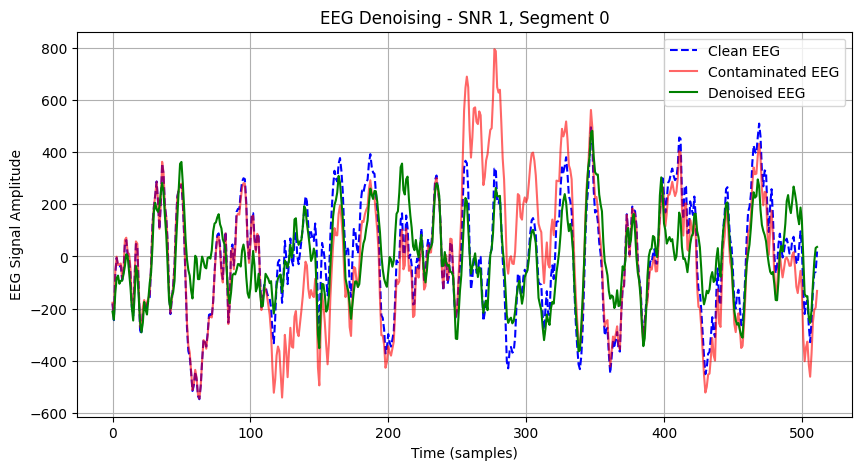

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 🔹 Ensure you have the correct dataset and model loaded before running this script.

# Select SNR=1 and 0th segment
snr_level = 1
snr_idx = list(sorted(synthetic_eeg_eog.keys())).index(snr_level)  # Find the index of SNR=1

# Get test data from pre-split test set
noisy_snr = X_test_list[snr_idx].cpu().numpy()  # Noisy (contaminated) EEG
clean_snr = y_test_list[snr_idx].cpu().numpy()  # Clean EEG

# Convert to PyTorch tensor and denoise
noisy_tensor = torch.tensor(noisy_snr, dtype=torch.float32).to(device)  # (batch, 512, 1)
denoised_tensor = model(noisy_tensor).cpu().detach().numpy()
denoised_tensor = denoised_tensor.reshape(clean_snr.shape)  # Ensure correct shape

# Select the 0th segment (first sample)
segment_idx = 0
noisy_segment = noisy_snr[segment_idx]
clean_segment = clean_snr[segment_idx]
denoised_segment = denoised_tensor[segment_idx]

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(clean_segment, label="Clean EEG", color="blue", linestyle="dashed", linewidth=1.5)
plt.plot(noisy_segment, label="Contaminated EEG", color="red", alpha=0.6)
plt.plot(denoised_segment, label="Denoised EEG", color="green", linewidth=1.5)

plt.xlabel("Time (samples)")
plt.ylabel("EEG Signal Amplitude")
plt.title(f"EEG Denoising - SNR {snr_level}, Segment {segment_idx}")
plt.legend()
plt.grid(True)
plt.show()
